In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/Users/cheyen/Desktop/projet_certification/DL_BLOC4/dataset/spam.csv', encoding='ISO-8859-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### 1. Data Exploration

In [3]:
print(data.shape)
print()
print(data.info())

(5572, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


In [4]:
data.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [5]:
data.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [6]:
data['v1'].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

<Axes: xlabel='v1', ylabel='Count'>

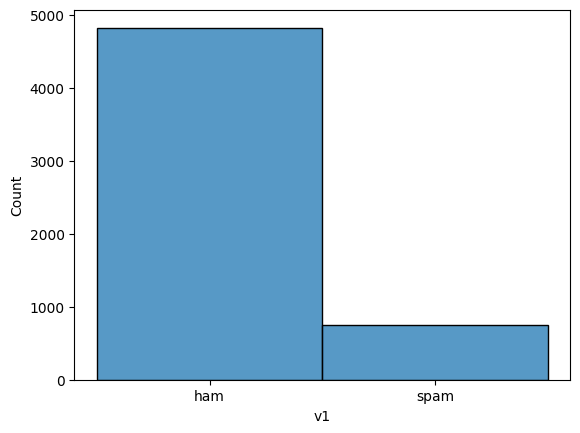

In [7]:
sns.histplot(data, x='v1')

### 2. Data Preparation

In [8]:
df = data.copy()

In [9]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df['v2'] = df['v2'].str.lower()
df.head()

,v1,v2
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


In [11]:
indesirable = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
for punct in indesirable:
    df['v2'] = df['v2'].str.replace(punct, '')

In [12]:
new_columns_name = ['category', 'message']
df.columns = new_columns_name

df['category'] = df['category'].replace({'spam' : 1, 'ham' : 0})
df.head()

,category,message
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...


In [13]:
# Download model 
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [14]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [15]:
def tokenize_text_spacy(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return tokens

# Appliquer la tokenization à la colonne "message"
df['message_tokens'] = df['message'].apply(tokenize_text_spacy)

In [16]:
def remove_stop_words_spacy(tokens):
    doc = nlp(' '.join(tokens))  # Créer un Doc spaCy à partir des tokens
    tokens_without_stop_words = [token.text for token in doc if not token.is_stop]
    return ' '.join(tokens_without_stop_words)

# Appliquer la suppression des stop words à la colonne "message_tokens"
df['message_tokens'] = df['message_tokens'].apply(remove_stop_words_spacy)

In [17]:
df.head()

,category,message,message_tokens
0,0,go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...
1,0,ok lar joking wif u oni,ok lar joking wif u oni
2,1,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say so early hor u c already then say,u dun early hor u c
4,0,nah i dont think he goes to usf he lives aroun...,nah nt think goes usf lives


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vector
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['message_tokens'])

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

# Diviser les données en ensembles d'entraînement, de validation et de test
X_train, X_test, y_train, y_test = train_test_split(X, df['category'], test_size=0.2, stratify=df['category'])

In [20]:
#Convert the CSR matrix to a dense matrix
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [21]:
# Construction du modèle de Deep Learning
model = Sequential()
model.add(Dense(32, input_shape=(X_train_dense.shape[1],), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                293632    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 293665 (1.12 MB)
Trainable params: 293665 (1.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# Entraînement du modèle
history = model.fit(X_train_dense, y_train, epochs=10, batch_size=32, validation_data=(X_test_dense, y_test), verbose=0)

# Évaluer le modèle sur les données de test
loss, accuracy = model.evaluate(X_test_dense, y_test)
print(f'Test accuracy: {accuracy}')

35/35 [==============================] - 0s 765us/step - loss: 0.0472 - accuracy: 0.9848
Test accuracy: 0.9847533702850342


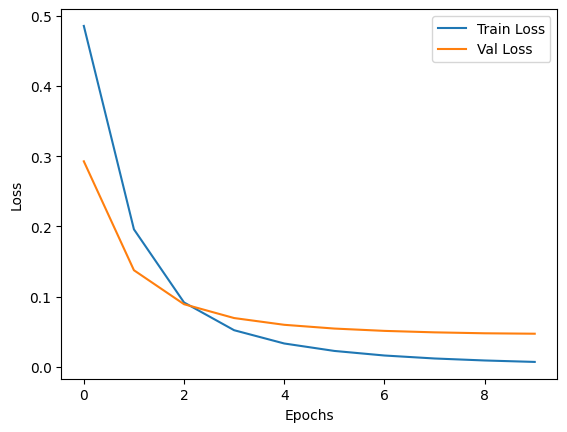

In [24]:
# Tracer les courbes d'apprentissage
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
y_pred = model.predict(X_test_dense)
y_pred = np.where(y_pred>0.5,1,0)

35/35 [==============================] - 0s 696us/step


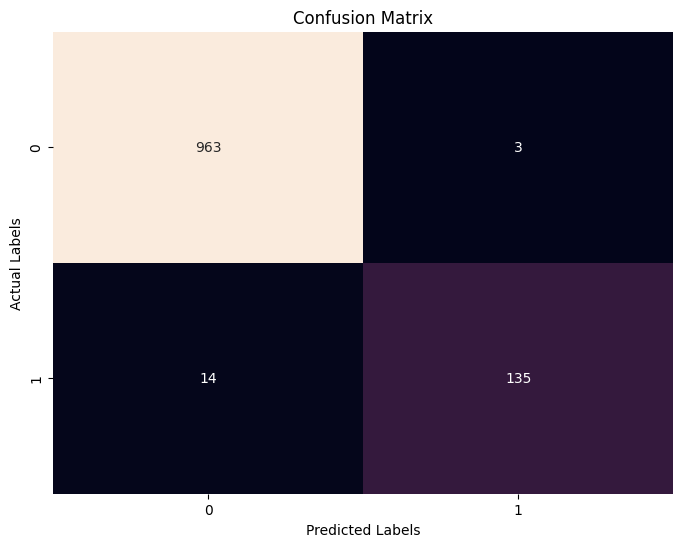

In [26]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.98      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115

